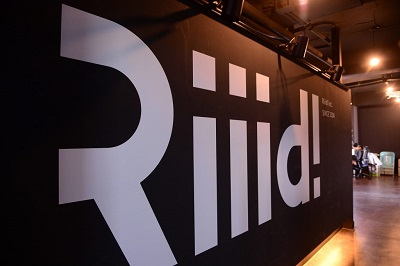

**In this competition, your challenge is to create algorithms for "Knowledge Tracing," the modeling of student knowledge over time. The goal is to accurately predict how students will perform on future interactions. You will pair your machine learning skills using Riiid’s EdNet data.**

# Contents
* [1. Import libraries](#1)
* [2. Train.csv](#2)
* [3. Questions.csv](#3)
* [4. Lectures.csv](#4)


<a id="1"></a>
# 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt



<a id="2"></a>
# 2. Train.csv

* **row_id: (int64)** ID code for the row.
* **timestamp: (int64)** the time in milliseconds between this user interaction and the first event completion from that user.
* **user_id: (int32)** ID code for the user.
* **content_id: (int16)** ID code for the user interaction
* **content_type_id: (int8)** 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* **task_container_id: (int16)** Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* **user_answer: (int8)** the user's answer to the question, if any. Read -1 as null, for lectures.
* **answered_correctly: (int8)** if the user responded correctly. Read -1 as null, for lectures.
* **prior_question_elapsed_time: (float32)** The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* **prior_question_had_explanation: (bool)** Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

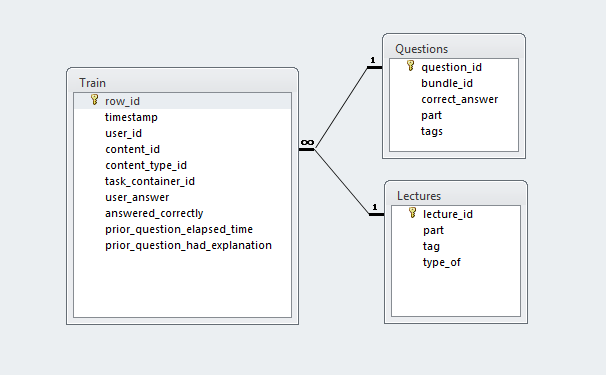

In [ ]:
%%time
# Read in data
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    'prior_question_had_explanation': 'boolean'
}

# reading the dataset from raw csv file
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
import datatable as dt
df = dt.fread("../input/riiid-test-answer-prediction/train.csv", max_nrows=30000000).to_pandas() #

#df = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', nrows=10**6 , dtype=dtypes)


In [ ]:
df.info()

In [ ]:
df.head(15).T

In [ ]:
df.describe().T

In [ ]:
#discovering null values in data
df.isnull().sum()

In [ ]:
#discovering unique values in data
cols = df.columns
for c in cols: 
    print(f' The unique values in {c} :{df[c].nunique()}')

###Visualizing number of questions and lectures

In [ ]:
# visualizing number of questions and lectures
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df['content_type_id'], palette=['#557799',"#990000"])
ax.set_xlabel('content Type (False:question**True:Lecture)',size=15)
plt.title("number of questions and lectures",size=15)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [ ]:
# getting just questions
df_questions=df[df.content_type_id==0]
df_questions.shape

 ### Correct VS Incorrect answers

In [ ]:
# Correct VS Incorrect answers
df_questions_correct = df_questions['answered_correctly'].value_counts().reset_index()
df_questions_correct.columns = ['answered_correctly','presentage']
df_questions_correct['presentage'] /= len(df_questions)
df_questions_correct

### User answers (0,1,2 or 3)

In [ ]:
# User answers (0,1,2 or 3)
df_questions_answer = df_questions['user_answer'].value_counts().reset_index()
df_questions_answer.columns = ['user_answer','presentage']
df_questions_answer['presentage'] /= len(df_questions)
df_questions_answer

### correct answer AND  user answer

In [ ]:
# visualizing correct answer 
explode = (0.1,0.1)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
labels = ('Correct', 'Incorrect')
ax1.pie(df_questions_correct['presentage'],explode=explode,labels = labels, autopct = '%.2f%%',startangle = 90, 
                                       colors=['#368f71',"#d12c3a"],textprops=dict(color="#000000",size=14))
ax1.axis('equal')
ax1.set_title("Answered Correctly" ,size=15) 
# # visualizing  user answer
explode = (0.1,0.1,0,0)
ax2.pie(df_questions_answer['presentage'],explode=explode,labels = df_questions_answer['user_answer'], autopct = '%.2f%%',startangle = 90 ,
                                        colors=['#6381fc',"#cccc00","#d12c3a","#368f71"],textprops=dict(color="#000000",size=14))
ax2.axis('equal')
ax2.set_title("Users Answer",size=15) 


### user answer(0,1,2,or 3) vs Correct answer

In [ ]:
# visualizing user answer(0,1,2,or 3) vs Correct answer
plt.figure(figsize=(10,6))
ax=sns.countplot(df_questions['user_answer'], hue=df_questions['answered_correctly'], palette=['#d12c3a',"#368f71"], alpha=1)
ax.set_xlabel('User answer 0,1,2 or 3',size=15)   
ax.legend(bbox_to_anchor=(1.1, 0.5),labels=['Incorrect','Correct'])
plt.title('user answer vs correct answer', fontsize = 20)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Grouping correct answer by users

In [ ]:
# Grouping correct answer by users
df_questions_gby_user = df_questions.groupby('user_id').agg({'answered_correctly': 'sum', 'row_id':'count'})
df_questions_gby_user.columns = ['answered_correctly','All answers']
df_questions_gby_user

### Correct answer by users

In [ ]:
# visualizing Correct answer by users
plt.figure(figsize = (16,8))
ax=sns.distplot(df_questions_gby_user['answered_correctly'] /df_questions_gby_user['All answers']*100,color='#557799',hist_kws={'alpha':1,"linewidth": 1}, kde_kws={"color": "black", "lw": 1, "label": ""})
plt.title('Correct answers percentage by users', fontdict = {'size': 15})
plt.xlabel('Percentage of correct answers', size = 15)

 ### The twenty most used questions (content_id) 

In [ ]:
nlargest = df_questions.content_id.value_counts().nlargest(20)
fig = plt.figure(figsize=(18,6))
ax=nlargest.plot.bar(width=0.9,alpha=0.9,color='#557799')
plt.title("The twenty most used questions", size=15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

 ### The twenty least used questions (content_id) 

In [ ]:
%time
nsmallest = df_questions.content_id.value_counts().nsmallest(20)
fig = plt.figure(figsize=(18,6))
ax=nsmallest.plot.bar(width=0.9,alpha=0.9,color='#557799')
plt.title("The twenty least used questions",size=15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### The worst 20 percentage of correct answer for questions (content_id)

In [ ]:
dddd = df_questions.groupby('content_id').agg({'answered_correctly': 'sum', 'row_id':'count'})
dddd['presentage']=dddd['answered_correctly'] / dddd['row_id']
dddd=dddd.sort_values('presentage',ascending=True).head(20).reset_index()
dddd.columns = ['Content Id','CorrectAnswer','All Rows','presentage %']


fig, ax = plt.subplots(figsize=(17,5))
ax = sns.barplot(x=dddd['Content Id'], y=dddd['presentage %'],order = dddd['Content Id'], data=dddd)
plt.xlabel('Questions (Content Id)',size = 15)
plt.ylabel('presentage %',size = 15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### The best 20 percentage of correct answer for questions (content_id)

In [ ]:
dddd = df_questions.groupby('content_id').agg({'answered_correctly': 'sum', 'row_id':'count'})
dddd['presentage']=dddd['answered_correctly'] / dddd['row_id']
dddd=dddd.sort_values('presentage',ascending=False).head(20).reset_index()
dddd.columns = ['Content Id','CorrectAnswer','All Rows','presentage %']
fig, ax = plt.subplots(figsize=(17,5))
ax = sns.barplot(x=dddd['Content Id'], y=dddd['presentage %'],order = dddd['Content Id'], data=dddd)
plt.xlabel('Questions (Content Id)',size = 15)
plt.ylabel('presentage %',size = 15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Question elapsed time VS Answered Correctly

In [ ]:
#  Question elapsed time VS Answered Correctly
df_questions5=df_questions[(df_questions.prior_question_elapsed_time.notnull()) & (df_questions.prior_question_elapsed_time<15000)]
plt.figure(figsize = (5,7))
ax=sns.violinplot(data=df_questions5, x=df_questions5.answered_correctly, y=df_questions5.prior_question_elapsed_time, hue=df_questions5.answered_correctly,
                inner="quart", linewidth=2,palette=['#d12c3a',"#368f71"],)
ax.legend(bbox_to_anchor=(0.6, 1.0))
ax.set_xlabel('Answered Correctly',size=15) 
ax.set_ylabel('prior question elapsed time',size=15)


### Answered Correctly for first question (time=0)

In [ ]:
#  Answered Correctly for first question (time=0)
df_questions1=df_questions[df_questions.prior_question_elapsed_time.isnull()]
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_questions1['answered_correctly'],  palette=['#d12c3a',"#368f71"])
ax.set_xlabel('Answered Correctly',size=15)
ax.set_ylabel('',size=15)
plt.title("Answered Correctly for first question (time=0)",size=15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Distribution of  prior question elapsed time

In [ ]:
# Distribution of  prior question elapsed time
plt.figure(figsize = (16,8))
ax=sns.distplot(df_questions['prior_question_elapsed_time'],color='#557799',hist_kws={'alpha':1,"linewidth": 1}, kde_kws={"color": "black", "lw": 1, "label": ""})
plt.title('Distribution of  prior question elapsed time', fontdict = {'size': 15})
plt.xlabel('prior question elapsed time', size = 15)

### Distribution of  timestamp

In [ ]:
plt.figure(figsize = (16,8))
ax=sns.distplot(df_questions['timestamp']/(31536000000/365),color='#557799',hist_kws={'alpha':1,"linewidth": 1}, kde_kws={"color": "black", "lw": 1, "label": ""})
plt.title('Distribution of  timestamp', fontdict = {'size': 15})
plt.xlabel('timestamp', size = 15)

### Answered_correctly Vs Prior Question had explanation

In [ ]:
pq = df_questions.groupby(['prior_question_had_explanation']).agg({'answered_correctly': ['mean']}).reset_index()
pq.columns = ['prior_question_had_explanation','Percent answered correctly']
explode = (0.1,0)
fig,ax = plt.subplots(figsize=(12,5))
ax.pie(pq['Percent answered correctly'],labels = pq['prior_question_had_explanation'],explode=explode, autopct = '%.2f%%',startangle = 90,
                                        colors=["#d12c3a","#368f71"],textprops=dict(color="#000000",size=14))

ax.set_title("Answered_correctly Vs Prior Question had explanation",size=15) 

<a id="3"></a>
# 3. Questions.csv

* **question_id:** foreign key for the train/test content_id column, when the content type is question (0).
* **bundle_id:** code for which questions are served together.
* **correct_answer:** the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* **part:** the relevant section of the TOEIC test.
* **tags:** one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [ ]:
df_q=pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
df_q.sample(10).T

### Top 20 used Tags

In [ ]:
df_tag = df_q['tags'].str.split(' ').explode('tags').reset_index()
df_tag = df_tag['tags'].value_counts().reset_index()
df_tag.columns = ['tag', 'count']
df_tag = df_tag.sort_values(['count'])

In [ ]:
df_tag=df_tag.tail(20)
fig, ax = plt.subplots(figsize=(17,5))
ax = sns.barplot(x=df_tag['tag'], y=df_tag['count'],order = df_tag['tag'], data=df_tag)
plt.xlabel('Tag',size = 15)
plt.ylabel('Count',size = 15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

### Distribution of Parts

In [ ]:
%time
dp = df_q['part'].value_counts().reset_index()
dp.columns = ['part', 'count']


df_tag=df_tag.tail(20)
fig, ax = plt.subplots(figsize=(17,5))
ax = sns.barplot(x=dp['part'], y=dp['count'], data=dp)
plt.xlabel('Parts',size = 15)
plt.ylabel('Count',size = 15)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

<a id="4"></a>
# 4. Lectures.csv

* **lecture_id:** foreign key for the train/test content_id column, when the content type is lecture (1).
* **part:** top level category code for the lecture.
* **tag:** one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* **type_of:** brief description of the core purpose of the lecture